# Computational Physics
## Numerical Quadrature

<img src="https://upload.wikimedia.org/wikipedia/commons/f/f2/Integral_as_region_under_curve.svg" width=500px>

## Last Time

- Simultaneous over relaxation (SOR)
- Application to the Poisson equation (finite charge density)

## Today

- Solving for the magnetic field
- Approximating integrals

## Setting up the Notebook

In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('../include/notebook.mplstyle');
%config InlineBackend.figure_format = 'retina'
colors = ["#2078B5", "#FF7F0F", "#2CA12C", "#D72827", "#9467BE", "#8C574B",
            "#E478C2", "#808080", "#BCBE20", "#17BED0", "#AEC8E9", "#FFBC79", 
            "#98E08B", "#FF9896", "#C6B1D6", "#C59D94", "#F8B7D3", "#C8C8C8", 
           "#DCDC8E", "#9EDAE6"]

## The Biot-Savart Law

The integral form of one of Maxwell's equations allows us to solve for the magnetic field $\vec{B}$ for situations with constant current:

\begin{equation}
\vec{B}(\vec{r}) = \frac{\mu_0}{4\pi} \int_C \frac{I \vec{d\ell} \times \vec{r'}}{r'^3}
\end{equation}

where $C$ is a curve parameterizing the wire carying current and $\vec{r'}$ is the distance between the current element $\vec{d\ell}$ and the point of measurement $\vec{r}$.

### Example: Field outside a helix.

Find the magnetic field around a current carrying helical wire that wraps around the $y$-axis parameterized by $w(t) = \left(\cos(\omega t),t,\sin(\omega t)\right)$ for $t \in (-4\pi,4\pi)$.

In [5]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.constants import pi as π

ω = 1

fig = plt.figure(figsize=plt.figaspect(1))
ax = fig.gca(projection='3d')

q = np.linspace(-16,16,1000)
t = np.linspace(-4*π, 4*π, 1000)
x = np.cos(ω*t)
y = t
z = np.sin(ω*t)
ax.plot(np.zeros_like(q),np.zeros_like(q),q, color='k', linewidth=1)
ax.plot(q,np.zeros_like(q),np.zeros_like(q), color='k', linewidth=1)
ax.plot(np.zeros_like(q),q,np.zeros_like(q), color='k', linewidth=1)
ax.plot(x, y, z)
ax.text(0,0,18, 'z', fontsize='18')
ax.text(0,18,0, 'y', fontsize='18')
ax.text(18,0,0, 'x', fontsize='18')
ax.view_init(25, 30)
plt.axis('off');

TypeError: gca() got an unexpected keyword argument 'projection'

<Figure size 288x288 with 0 Axes>

We find:

\begin{equation}
\vec{B} = \frac{\mu_0 I}{4\pi} \int_{-4\pi}^{4\pi} dt \frac{\left(z-\sin \omega t - \omega\cos \omega t(y-t), \omega\sin \omega t(z-\omega\sin \omega t) + \omega\cos \omega t (x-\omega\cos \omega t), - \omega \sin \omega t(y-t) - x + \omega \cos \omega t \right)}{\left[(x-\cos \omega t)^2 + (y-t)^2 + (z-\sin \omega t)^2\right]^{3/2}}
\end{equation}

This integral cannot be solved analytically *except* at some high-symmetry points.  Can we construct a general numerical method to do this?

In [6]:
def dBx(t,x,y,z,ω):
    '''x-component of the B field (in units of μ0I)'''
    r = (x-np.cos(ω*t))**2+(y-t)**2+(z-np.sin(ω*t))**2
    return (1/(4.0*π))*(z - np.sin(ω*t) - ω*np.cos(ω*t)*(y-t))/r**3/2

def dBy(t,x,y,z,ω):
    '''y-component of the B field (in units of μ0I)'''
    r = (x-np.cos(ω*t))**2+(y-t)**2+(z-np.sin(ω*t))**2
    return (1/(4.0*π))*(ω*np.sin(ω*t)*(z-np.sin(ω*t))+ω*np.cos(ω*t)*(x-np.cos(ω*t)))/r**3/2

def dBz(t,x,y,z,ω):
    '''z-component of the B field (in units of μ0I)'''
    r = (x-np.cos(ω*t))**2+(y-t)**2+(z-np.sin(ω*t))**2
    return (1/(4.0*π))*(-ω*np.sin(ω*t)*(y-t)-x+np.cos(ω*t))/r**3/2

## Newton-Cotes Quadrature

Consider the general definite integral:

\begin{equation}
I = \int_a^b f(x) dx
\end{equation}

and consider breaking up the region of integration into $N$ equally sized regions of size:

\begin{equation}
\Delta x = \frac{b-a}{N}
\end{equation}

where $N \in \mathbb{Z} \gg 1$.  The first step is to break up the integral into $N$ pieces:

\begin{align}
I &= \int_a^b f(x) dx \newline
&= \int_{x_0}^{x_1} f(x) dx + \int_{x_1}^{x_2} f(x) dx + \cdots + \int_{x_{N-1}}^{x_N} f(x) dx \newline
&= \sum_{i=0}^{N-1} \int_{x_i}^{x_{i+1}} f(x) dx
\end{align}

where we have defined $x_i = a + i\Delta x$.  Different numerical integration algorthims correspond to different approximations for the *top* of the panels.

### Rectangular Rule

We replace the function with a constant value:

\begin{equation}
I_R = \int_{a}^{b} f(x) dx \approx \sum_{i=0}^{N-1} f(x_i) \Delta x .
\end{equation}

### Trapezoidal Rule
We can do better using a Taylor expansion at lowest order which provides a linear approximation to the function. 

\begin{align}
I_i &= \int_{x_i}^{x_{i+1}} f(x) dx \approx \Delta x \left[f(x_i) + \frac{1}{2}\left(f(x_{i+1})-f(x_i)\right) \right] \newline
&\approx  \frac{\Delta x}{2} \left[f(x_{i+1}) + f(x_i) \right]
\end{align}

Summing over all panels:

\begin{equation}
I_T   \approx \frac{\Delta x}{2} \left[f(a) + f(b) \right] +  \sum_{i=1}^{N-1} f(x_i) \Delta x .
\end{equation}

<div class="span alert alert-success">
<h2>  Programming challenge </h2>

Complete the code below to implement the trapezoidal rule.

</div>

In [8]:
def trapezoidal_rule(f,x,*params):
    '''The trapezoidal rule for numerical integration of f(x) over x.'''
    
    a,b = x[0],x[-1]
    Δx = x[1] - x[0]
    I = 0
    
    I += 0.5*Δx*(f(a,*params)+f(b,*params))
    for n in range(1,x.size-1):
        I += Δx*f(x[n],*params)
        
    # return Δx*(0.5*(f(a,*params)+f(b,*params)) + np.sum([f(cx,*params) for cx in x[1:-1]]))
    
    return I

### Let's look at the magnetic field components along the $y$-axis

In [9]:
N = 500
t = np.linspace(-4*π,4*π,N)

# along the axis
y = np.linspace(-20,20,N)
x,z = 0,0

Bx = np.zeros_like(y)
By = np.zeros_like(y)
Bz = np.zeros_like(y)

for i in range(N):
    Bx[i] = trapezoidal_rule(dBx,t,x,y[i],z,ω)
    By[i] = trapezoidal_rule(dBy,t,x,y[i],z,ω)
    Bz[i] = trapezoidal_rule(dBz,t,x,y[i],z,ω)

Text(0, 0.5, '$B/\\mu_0 I$')

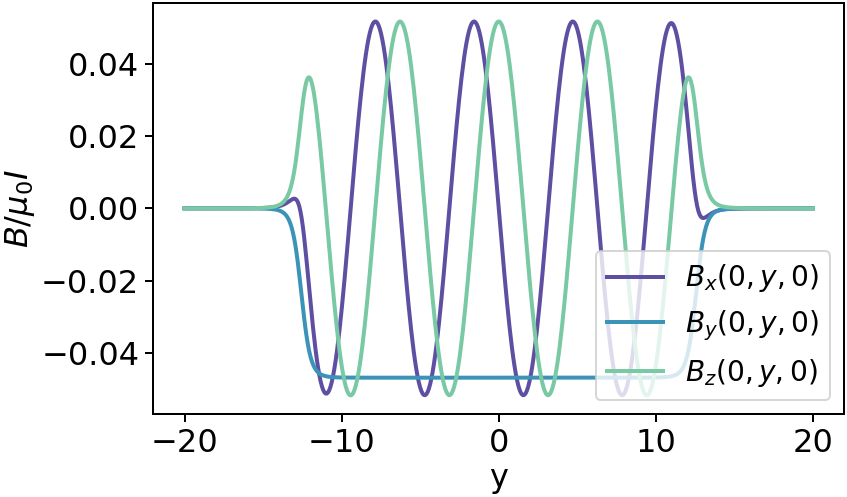

In [10]:
plt.plot(y,Bx,label=r'$B_x(0,y,0)$')
plt.plot(y,By, label=r'$B_y(0,y,0)$')
plt.plot(y,Bz, label=r'$B_z(0,y,0)$')

plt.legend(frameon=True, loc='lower right')
plt.xlabel('y')
plt.ylabel(r'$B/\mu_0 I$')

## How do we determine the error in these expressions?

Consider the [Euler-Maclaurin series](https://en.wikipedia.org/wiki/Euler%E2%80%93Maclaurin_formula) for the discrete function $f(i)$:

\begin{equation}
\sum_{i=0}^{N-1} f(i) = \int_0^N f(u) du - \frac{1}{2} \left[f(0) + f(N) \right] + \sum_{k=1}^\infty \frac{B_{2k}}{(2k\!)} \left[f^{(2k-1)}(N) - f^{(2k-1)}(0) \right] (\Delta x)^{2k-1}
\end{equation}

where $B_{2k}$ are the [Bernoulii numbers](https://en.wikipedia.org/wiki/Bernoulli_number) and $f^{(k)} = d^k f(u)/du^k$.

If we make the variable transformation: $x = u \Delta x + a$ then $u =0 \Rightarrow x=a$ and $u=N \Rightarrow x=b$.  Also on the LHS, when $u=i$ we have the discrete position $x_i$.  We can write:

\begin{equation}
\sum_{i=0}^{N-1} f(x_i) = \frac{1}{\Delta x} \int_{a}^{b} f(x) dx - \frac{1}{2}\left[ f(a) + f(b)\right] +  \sum_{k=1}^\infty \frac{B_{2k}}{(2k\!)} \left[f^{(2k-1)}(b) - f^{(2k-1)}(a) \right] (\Delta x)^{2k-1}
\end{equation}

and multiplying by $\Delta x$ and rearranging such that our integral $I$ is on the LHS we find:

\begin{equation}
\int_{a}^{b} f(x) dx = \sum_{i=0}^{N-1} \Delta x f(x_i) + \frac{\Delta x}{2}\left[ f(a) + f(b)\right]  -  \frac{(\Delta x)^2}{12} \left[f'(b) - f'(a) \right] + \mathrm{O}\left(\Delta x^4\right) .
\end{equation}

Therefore we see that the errors are:

\begin{align}
\text{Rectangular:} \quad & \quad \mathrm{O}{\left(\Delta x\right)} \newline
\text{Trapezoidal:} \quad & \quad \mathrm{O}{\left(\Delta x^2\right)}
\end{align}

where we note that things can go seriously wrong when we have a divergent derivative at the endpoints. 